In [1]:
import access
from access import Access, weights, Datasets
import geopandas as gpd
import gzip
import os
import pandas as pd
import pathlib
from shapely import wkt
import subprocess
from typing import List, Tuple, Union

/data/keeling/a/michels9/anaconda3/envs/tcm/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/data/cigi/scratch/michels9/tmp/ipykernel_48569/817756366.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be

In [2]:
def get_git_revision_hash() -> str:
    # from here: https://stackoverflow.com/questions/14989858/get-the-current-git-hash-in-a-python-script 
    return subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode('ascii').strip()

In [3]:
## debugging information
print("\n**Debugging information**\n")
print(f"pysal/access version: {access.__version__}")
print(f"Git commit hash {get_git_revision_hash()}")
print("\n**End debugging info**\n\n")


**Debugging information**

pysal/access version: 1.1.9
Git commit hash 167585f83b83beb501f0a0a4455ecb84ad9e99f4

**End debugging info**




## TODO

* allow for multi-select for methods
* input data for population
* allow supply data file to be named anything
* allow supply data file to be any data type
* input data for travel times

In [4]:
# set variables to be read in, only used for debugging purposes, get variables from end-user

os.environ["result_folder"] = "result"
os.environ['param_mobility_mode'] = "DRIVING"
os.environ['param_population_type'] = "ZIP"
os.environ['param_max_travel_time'] = "90"
os.environ['param_access_measure'] = "ALL"


# VARIOUS SUPPLY DATASETS ON KEELING IN THE HEROP_DATA_DIR PATH

os.environ['param_supply_filename'] = "supply/ContinentalHospitals.shp"
os.environ['param_supply_capacity'] = "BEDS"
os.environ['param_supply_latlon_or_id'] = "ID"
os.environ['param_supply_lat'] = ""
os.environ['param_supply_lon'] = ""
os.environ['param_supply_id'] = "ZIP"

# os.environ['param_supply_filename'] = "supply/chi_doc_pysal.csv"
# os.environ['param_supply_capacity'] = "doc"
# os.environ['param_supply_latlon_or_id'] = "ID"
# os.environ['param_supply_lat'] = ""
# os.environ['param_supply_lon'] = ""
# os.environ['param_supply_id'] = "geoid"

# os.environ['param_supply_filename'] = "supply/chi_hospitals_pysal.csv"
# os.environ['param_supply_capacity'] = ""  # just count num hospitals
# os.environ['param_supply_latlon_or_id'] = "LATLON"
# os.environ['param_supply_lat'] = ""
# os.environ['param_supply_lon'] = ""
# os.environ['param_supply_id'] = ""

# data folder depends on running in container vs. directly on Keeling
HEROP_DATA_DIR = "/data/keeling/a/michels9/common/michels9/herop_access_data"  # directly on keeling
# HEROP_DATA_DIR = "/job/herop_access_data"  # path we map that directory to in the container

In [5]:
# general CyberGIS-Compute variables that will be useful
RESULT_FOLDER = os.getenv('result_folder')  # data that will be sent to the end user
DATA_FOLDER = os.getenv('data_folder')  # data input from the end user

# get the appropriate variables, these will be passed by CyberGIS-Compute
MOBILITY_MODE = os.getenv('param_mobility_mode')
POPULATION_TYPE = os.getenv('param_population_type')
MAX_TRAVEL_TIME = os.getenv('param_max_travel_time')
ACCESS_MEASURE = os.getenv('param_access_measure')
SUPPLY_FILENAME = os.getenv('param_supply_filename')

# # supply data
SUPPLY_CAPACITY = os.getenv('param_supply_capacity')
SUPPLY_LATLON_OR_ID = os.getenv('param_supply_latlon_or_id')
SUPPLY_LAT = os.getenv('param_supply_lat')
SUPPLY_LON = os.getenv('param_supply_lon')
SUPPLY_ID = os.getenv('param_supply_id')

In [6]:
# changed to use the env vars
# set the appropriate variables for the supply datasets available
# if SUPPLY_FILENAME == "supply/ContinentalHospitals.shp":
#     SUPPLY_CAPACITY = "BEDS"
#     SUPPLY_LATLON_OR_ID = "ID"
#     SUPPLY_LAT = ""
#     SUPPLY_LON = ""
#     SUPPLY_ID = "ZIP"
# elif SUPPLY_FILENAME == "supply/chi_doc_pysal.csv":
#     SUPPLY_CAPACITY = "doc"
#     SUPPLY_LATLON_OR_ID = "ID"
#     SUPPLY_LAT = ""
#     SUPPLY_LON = ""
#     SUPPLY_ID = "geoid"
# elif SUPPLY_FILENAME == "supply/chi_hospitals_pysal.csv":
#     SUPPLY_CAPACITY = ""  # just counting cummulative hospitals
#     SUPPLY_LATLON_OR_ID = "LATLON"
#     SUPPLY_LAT = ""  # these can be blank if the dataset already has a geometry field
#     SUPPLY_LON = ""
#     SUPPLY_ID = ""

In [7]:
# geography data
geo_join_col = "GEOID" if POPULATION_TYPE == 'TRACT' else "ZCTA5CE10"

# population data
population_join_col = 'FIPS' if POPULATION_TYPE == "TRACT" else "5-digit ZIP Code Tabulation Area"  # TODO: is this always FIPS? Definitely won't be if people upload data?
population_data_col = "Total Population"  # TODO: is this always Total Population?

# travel time data
matrix_join_col_o: str = "origin"
matrix_join_col_d: str = "destination"
matrix_travel_cost_col: str = "minutes"

In [8]:
MAX_TRAVEL_TIME = int(MAX_TRAVEL_TIME)

## TODO: add a ton of sanity checks

* make sure the capacity field non-nan depending on the method

## Helper Functions

Helper functions taken from the HEROP spatial access lambda functions to reduce code reuse whereever possible: https://github.com/healthyregions/spatial-access/blob/main/lambda_functions

In [9]:
def dfToGdf(df, lon, lat, crs='EPSG:4326'):
  '''
  Taken from: https://github.com/healthyregions/spatial-access/blob/main/lambda_functions/metrics.py#L11
    df: pandas dataframe
    lon: longitude column name
    lat: latitude column name
    crs: EPSG code or similar coordinate reference system
  '''
  return gpd.GeoDataFrame(
    df.drop([lon, lat], axis=1), crs=crs, geometry=[Point(xy) for xy in zip(df[lon], df[lat])])

## Population and Geography Data

In [10]:
def load_geometry() -> gpd.GeoDataFrame:
    """
    Loads the geometry data for the analysis.
    
    Returns:
        Tuple[gpd.GeoDataFrame, List]: (Geometry, list of unique origin IDs)
    """
    if POPULATION_TYPE == "TRACT":
        geometry = gpd.read_file(os.path.join(HEROP_DATA_DIR, "cb_2019_us_tract_500k.shp"))
        
    elif POPULATION_TYPE == "ZIP":
        geometry = gpd.read_file(os.path.join(HEROP_DATA_DIR, "cb_2018_us_zcta510_500k.shp"))
    else:
        raise Exception(f"POPULATION_TYPE should be TRACT or ZIP, somehow got {POPULATION_TYPE}")
    geometry = geometry.to_crs("EPSG:4326")
    print(list(geometry.columns))
    geometry = geometry[[geo_join_col, "geometry"]]
    # coerce the field to an int64
    # TODO: do we always want to coerce to int64?
    try:
        geometry[geo_join_col] = geometry[geo_join_col].astype('int64')
    except Exception as e: 
        print(f" Error in self.geographies[self.geo_join_col] : {e} ")
    return geometry

In [11]:
def load_population() -> gpd.GeoDataFrame:
    if POPULATION_TYPE == "TRACT":
        population = gpd.read_file(os.path.join(HEROP_DATA_DIR, "DEFAULT_POP_DATA_TRACT.csv")).iloc[1:]
    elif POPULATION_TYPE == "ZIP":
        population = gpd.read_file(os.path.join(HEROP_DATA_DIR, "DEFAULT_POP_DATA_ZIP.csv")).iloc[1:]
    else:
        raise Exception(f"POPULATION_TYPE should be TRACT or ZIP, somehow got {POPULATION_TYPE}")
    # TODO: for now just coercing to int64, revisit later
    try:
        population[population_join_col] = population[population_join_col].astype('int64')
    except Exception as e: 
        print(f" Error in population[population_join_col] : {e} ")
    population = population[[population_join_col, population_data_col]]
    # join to geometry data
    geometry = load_geometry()
    try:
        geometry = geometry.merge(
            population,
            how="left",
            left_on=geo_join_col,
            right_on=population_join_col
        )
    except Exception as e:
        print(f" Error in self.geographies.merge : {e} ") # 'zip' error is here
    population[population_data_col] = population[population_data_col].astype('float')
    return population

In [12]:
population = load_population()
print(f"Population loaded with {len(population)} rows: {population.head()}")

['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10', 'geometry']
Population loaded with 33120 rows:    5-digit ZIP Code Tabulation Area  Total Population
1                               601           17113.0
2                               602           37751.0
3                               603           47081.0
4                               606            6392.0
5                               610           26686.0


## Supply Data

In [13]:
# load the supply data
def get_supply_data():
    # load the data from the data_dir
    global SUPPLY_ID
    if SUPPLY_FILENAME in [
        "supply/ContinentalHospitals.shp",
        "supply/chi_doc_pysal.csv",
        "supply/chi_hospitals_pysal.csv"
    ]:  # CHECKS IF IT IS ONE OF OUR DEFAULT DATASETS
        supply_data_path = os.path.join(HEROP_DATA_DIR, SUPPLY_FILENAME)
    else:  # else use the data_dir which holds user-provided data
        supply_data_path = os.path.join(DATA_DIR, SUPPLY_FILENAME)
    try:
        supply_df = gpd.read_file(supply_data_path)
    except ValueError as e:
        print(f"Caught ValueError: {e}\n Trying to load as CSV...")
        supply_df = pd.read_csv(supply_data_path)
        if "geometry" in supply_df.columns:
            try:
                supply_df['geometry'] = supply_df['geometry'].apply(wkt.loads)
                supply_df = gpd.GeoDataFrame(supply_df, crs='epsg:4326')
            except Exception as e:
                print(f"In get_supply_data: attempted to convert geometry column from {supply_data_path} to geometry as WKT, but failed with: {e}")
    if SUPPLY_LATLON_OR_ID == "ID":  # if using geoid
        assert SUPPLY_ID in supply_df.columns
    elif SUPPLY_LATLON_OR_ID == "LATLON":  # if using lat/lon
        if "geometry" not in supply_df.columns:  # allow for geospatial data inputs
            # load the geometry data we will map to
            geometry = load_geometry()
            print(f"Setting supply using Lat/Lon columns {SUPPLY_LAT}/{SUPPLY_LON}:\n {supply_df.head()}")
            supply_df = dfToGdf(supply_df, SUPPLY_LAT, SUPPLY_LON)
            supply_df = gpd.sjoin(geometry[[geo_join_col, 'geometry']], supply_df, how='inner', predicate='intersects')
        else:
            # load the geometry data we will map to
            geometry = load_geometry()
            print(f"Setting supply using geometry column:\n {supply_df.head()}")
            supply_df = gpd.sjoin(geometry[[geo_join_col, 'geometry']], supply_df, how='inner', predicate='intersects')
        # in set_destination, gdf is GEOID_left FIPS ... index_right GEOID_right
        supply_df = pd.DataFrame(supply_df)
        SUPPLY_ID = geo_join_col
    else:
        raise Exception(f"SUPPLY_LATLON_OR_ID should be ID or LATLON, somehow got {SUPPLY_LATLON_OR_ID}")
    global SUPPLY_CAPACITY
    if SUPPLY_CAPACITY == "":
        SUPPLY_CAPACITY = "# of Opportunities"  # TODO: HARD-CODE BAD
        print(SUPPLY_CAPACITY)
        supply_df[SUPPLY_CAPACITY] = 1  # set every resource/opportunity to 1
    print(SUPPLY_CAPACITY)
    print(f"supply_df is {supply_df.columns}")
    supply_df = supply_df[[SUPPLY_CAPACITY, SUPPLY_ID]]
    try:
        supply_df[SUPPLY_CAPACITY] = supply_df[SUPPLY_CAPACITY].astype('float')
    except Exception as e: 
        print(f" Error when coercing supply_df[SUPPLY_CAPACITY] to float : {e} ")
    print(supply_df.dtypes)
    print(supply_df.head())
    supply_df = supply_df[supply_df[SUPPLY_CAPACITY] > 0]  # drop 0 and negative supply
    # sum up for duplicates (e.g. hospitals in the same ZCTA)
    supply_df = supply_df.groupby(SUPPLY_ID, as_index=False)[SUPPLY_CAPACITY].sum()
    supply_df[SUPPLY_ID] = supply_df[SUPPLY_ID].astype('int64')
    return supply_df

In [14]:
supply = get_supply_data()
print(f"Supply loaded with {len(supply)} rows")
supply.head()

BEDS
supply_df is Index(['OBJECTID', 'ID', 'NAME', 'ADDRESS', 'CITY', 'STATE', 'ZIP', 'ZIP4',
       'TELEPHONE', 'TYPE', 'STATUS', 'POPULATION', 'COUNTY', 'COUNTYFIPS',
       'COUNTRY', 'LATITUDE', 'LONGITUDE', 'NAICS_CODE', 'NAICS_DESC',
       'SOURCE', 'SOURCEDATE', 'VAL_METHOD', 'VAL_DATE', 'WEBSITE', 'STATE_ID',
       'ALT_NAME', 'ST_FIPS', 'OWNER', 'TTL_STAFF', 'BEDS', 'TRAUMA',
       'HELIPAD', 'geometry'],
      dtype='object')
BEDS    float64
ZIP      object
dtype: object
    BEDS    ZIP
0   25.0  92363
1  226.0  92120
2   66.0  91942
3   70.0  92104
4  227.0  92050
Supply loaded with 5233 rows


## Load Travel Time

In [15]:
def get_transit_matrix():
#     MOBILITY_MODE = "WALKING"
#     POPULATION_TYPE = "TRACT"
    if POPULATION_TYPE == "TRACT" and MOBILITY_MODE == "DRIVING":
        path = os.path.join(HEROP_DATA_DIR, "US-matrix-TRACT-DRIVING")
        assert os.path.exists(path)  # quick sanity check, we can add more if necessary
        transit_matrix = pd.concat(
            pd.read_parquet(_file) for _file in pathlib.Path(path).glob("*.parquet")
        )
    else:
        path = os.path.join(HEROP_DATA_DIR, f"US-matrix-{POPULATION_TYPE}-{MOBILITY_MODE}.parquet")
        print(path)
        assert os.path.exists(path)  # quick sanity check, we can add more if necessary
        transit_matrix = pd.read_parquet(path)
    # quick sanity checking/cleaning
    _len = len(transit_matrix)
    transit_matrix = transit_matrix[transit_matrix[matrix_travel_cost_col] >= 0]
    transit_matrix = transit_matrix[transit_matrix[matrix_travel_cost_col] <= MAX_TRAVEL_TIME]  # drop past max
    # drop duplicates
    transit_matrix = transit_matrix.drop_duplicates(subset=[matrix_join_col_o, matrix_join_col_d])
    _cleaned_len = len(transit_matrix)
    print(f"After cleaning, transit_matrix is {len(transit_matrix)} rows ({_len - _cleaned_len} dropped)")
    transit_matrix[matrix_join_col_o] = transit_matrix[matrix_join_col_o].astype('int64')
    transit_matrix[matrix_join_col_d] = transit_matrix[matrix_join_col_d].astype('int64')
    return transit_matrix

In [16]:
print(f"US-matrix-{POPULATION_TYPE}-{MOBILITY_MODE}.parquet")

US-matrix-ZIP-DRIVING.parquet


In [17]:
# load the travel time data
transit_matrix = get_transit_matrix()
print(f"The transit matrix as {len(transit_matrix)} rows")
transit_matrix.head()

/data/keeling/a/michels9/common/michels9/herop_access_data/US-matrix-ZIP-DRIVING.parquet
After cleaning, transit_matrix is 5487083 rows (3852887 dropped)
The transit matrix as 5487083 rows


,origin,destination,minutes
0,1001,1001,0.00
1,1001,1002,44.46
2,1001,1003,46.47
3,1001,1005,74.97
4,1001,1007,41.48


In [18]:
# start by getting a collection of origins/destinations we have data for
possible_origins = set(population[population_join_col])
print(len(possible_origins))
possible_destinations = set(supply[SUPPLY_ID])
print(len(possible_destinations))

33120
5233


In [19]:
_len = len(transit_matrix)
# only keep data related to our origins
transit_matrix = transit_matrix[transit_matrix[matrix_join_col_o].isin(possible_origins)]
# only keep data related to our destinations
transit_matrix = transit_matrix[transit_matrix[matrix_join_col_d].isin(possible_destinations)]
print(f"Transit matrix is {len(transit_matrix)} after dropping data outside of study area (dropped {_len-len(transit_matrix)})")

Transit matrix is 943861 after dropping data outside of study area (dropped 4543222)


## Calculating Access

In [20]:
# create the "merged_data" DF
merged_data = transit_matrix.merge(
    supply,
    how="inner",
    left_on = matrix_join_col_d,
    right_on = SUPPLY_ID
)
print(len(merged_data))
merged_data.head()

943861


,origin,destination,minutes,ZIP,BEDS
0,1001,1040,19.88,1040,329.0
1,1002,1040,27.49,1040,329.0
2,1003,1040,29.33,1040,329.0
3,1005,1040,68.47,1040,329.0
4,1007,1040,25.68,1040,329.0


In [21]:
def analyze_nearest(merged_data) -> pd.DataFrame:
    time_to_nearest = merged_data.loc[merged_data.groupby(matrix_join_col_o)[matrix_travel_cost_col].idxmin()].reset_index(drop=True)[
        [matrix_join_col_o, matrix_travel_cost_col]]
    return time_to_nearest

In [22]:
def analyze_count_in_threshold(merged_data) -> pd.DataFrame:
    count_within_threshold = merged_data[merged_data[matrix_travel_cost_col] < MAX_TRAVEL_TIME] \
      .groupby(matrix_join_col_o).count() \
      .reset_index()[[matrix_join_col_o, matrix_travel_cost_col]] \
      .rename(columns={matrix_travel_cost_col: f"count in {MAX_TRAVEL_TIME}"})
    return count_within_threshold

In [23]:
# do the nearest time here
ttn = analyze_nearest(merged_data)
ttn.head()

,origin,minutes
0,1001,11.49
1,1002,27.49
2,1003,29.33
3,1005,29.70
4,1007,18.88


In [24]:
# count in threshold
cwt = analyze_count_in_threshold(merged_data)
cwt.head()

,origin,count in 90
0,1001,39
1,1002,34
2,1003,33
3,1005,53
4,1007,41


In [25]:
# create pysal/access object
A = Access(demand_df            = population,
           demand_index         = population_join_col,
           demand_value         = population_data_col,
           supply_df            = supply,
           supply_index         = SUPPLY_ID,
           supply_value         = SUPPLY_CAPACITY,
           cost_df              = transit_matrix,
           cost_origin          = matrix_join_col_o,
           cost_dest            = matrix_join_col_d,
           cost_name            = matrix_travel_cost_col,
           neighbor_cost_df              = transit_matrix,
           neighbor_cost_origin          = matrix_join_col_o,
           neighbor_cost_dest            = matrix_join_col_d,
           neighbor_cost_name            = matrix_travel_cost_col) # newer versions require this TCM

In [26]:
  # use a list so we can allow for multi later
if ACCESS_MEASURE == "ALL":
    # make it the full list
    metrics2run = [
        "GRAVITY",
        "FCA",
        "2SFCA",
        "E2SFCA",
        "G2SFCA",
        "3SFCA",
        "RAAM"
    ]
else:
    metrics2run = [ACCESS_MEASURE]
print(metrics2run)

['GRAVITY', 'FCA', '2SFCA', 'E2SFCA', 'G2SFCA', '3SFCA', 'RAAM']


In [27]:
if "GRAVITY" in metrics2run:
    gravity = weights.gravity(scale = 60, alpha = -1)
    A.weighted_catchment    (name = "gravity",  weight_fn = gravity)
if "FCA" in metrics2run:
    A.fca_ratio             (name = "fca",      max_cost = MAX_TRAVEL_TIME)
if "2SFCA" in metrics2run:
    A.two_stage_fca         (name = "2sfca",    max_cost = MAX_TRAVEL_TIME)
if "E2SFCA" in metrics2run:
    # create a weight function, this basic one just breaks it into thirds
    e2sfca_fn = weights.step_fn({MAX_TRAVEL_TIME/3 : 1, MAX_TRAVEL_TIME*(2/3) : 0.68, MAX_TRAVEL_TIME : 0.22})
    A.enhanced_two_stage_fca(name = "2sfca30",  weight_fn = e2sfca_fn)
if "G2SFCA" in metrics2run:
    # TODO: robustness on weights
    gaussian = weights.gaussian(MAX_TRAVEL_TIME/3)
    A.enhanced_two_stage_fca(name = "g2sfca",   weight_fn = gaussian)
if "3SFCA" in metrics2run:
    A.three_stage_fca       (name = "3sfca")
if "RAAM" in metrics2run:
    # TODO: let them pass in a TAU value
    A.raam(name = "raam", tau = 30)

/data/keeling/a/michels9/anaconda3/envs/tcm/lib/python3.8/site-packages/access/fca.py:161: UserWarning: some tracts may be unaccounted for in supply_cost
  warnings.warn("some tracts may be unaccounted for in supply_cost", stacklevel=1)


In [28]:
A.access_df.head()

,Total Population,gravity_BEDS,fca_BEDS,2sfca_BEDS,2sfca30_BEDS,g2sfca_BEDS,3sfca_BEDS,raam_BEDS
5-digit ZIP Code Tabulation Area,,,,,,,,
601,17113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
602,37751.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
603,47081.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
606,6392.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
610,26686.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Combine Results

In [29]:
results = load_geometry()
results = results \
            .merge(ttn, how="left", left_on=geo_join_col, right_on=matrix_join_col_o) \
            .merge(cwt, how="left", left_on=geo_join_col, right_on=matrix_join_col_o) 
results.head()

['ZCTA5CE10', 'AFFGEOID10', 'GEOID10', 'ALAND10', 'AWATER10', 'geometry']


,ZCTA5CE10,geometry,origin_x,minutes,origin_y,count in 90
0,36083,"MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ...",36083.0,36.03,36083.0,18.0
1,35441,"MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ...",35441.0,36.19,35441.0,8.0
2,35051,"POLYGON ((-86.74384 33.25002, -86.73802 33.251...",35051.0,30.44,35051.0,17.0
3,35121,"POLYGON ((-86.58527 33.94743, -86.58033 33.948...",35121.0,0.00,35121.0,19.0
4,35058,"MULTIPOLYGON (((-86.87884 34.21196, -86.87649 ...",35058.0,17.81,35058.0,20.0


In [30]:
results = results.merge(A.access_df, left_on=geo_join_col, right_index=True)
results.head()

,ZCTA5CE10,geometry,origin_x,minutes,origin_y,count in 90,Total Population,gravity_BEDS,fca_BEDS,2sfca_BEDS,2sfca30_BEDS,g2sfca_BEDS,3sfca_BEDS,raam_BEDS
0,36083,"MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ...",36083.0,36.03,36083.0,18.0,7316.0,3871.310357,0.008846,0.004138,0.003256,0.002592,0.000265,2.247007
1,35441,"MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ...",35441.0,36.19,35441.0,8.0,972.0,1456.834413,0.012228,0.001494,0.001919,0.001828,0.000235,2.125507
2,35051,"POLYGON ((-86.74384 33.25002, -86.73802 33.251...",35051.0,30.44,35051.0,17.0,9838.0,6120.042241,0.020060,0.003996,0.003422,0.001891,0.000326,2.176219
3,35121,"POLYGON ((-86.58527 33.94743, -86.58033 33.948...",35121.0,0.00,35121.0,19.0,16123.0,NaN,0.017111,0.003476,0.003741,0.002136,0.001884,1.681001
4,35058,"MULTIPOLYGON (((-86.87884 34.21196, -86.87649 ...",35058.0,17.81,35058.0,20.0,8630.0,5934.186676,0.016438,0.004553,0.002549,0.001573,0.002854,2.039794


In [31]:
results = results.drop(columns=["Total Population",
                                f"{matrix_join_col_o}_x",
                                f"{matrix_join_col_o}_y"], errors='ignore')

In [32]:
results.head()

,ZCTA5CE10,geometry,minutes,count in 90,gravity_BEDS,fca_BEDS,2sfca_BEDS,2sfca30_BEDS,g2sfca_BEDS,3sfca_BEDS,raam_BEDS
0,36083,"MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ...",36.03,18.0,3871.310357,0.008846,0.004138,0.003256,0.002592,0.000265,2.247007
1,35441,"MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ...",36.19,8.0,1456.834413,0.012228,0.001494,0.001919,0.001828,0.000235,2.125507
2,35051,"POLYGON ((-86.74384 33.25002, -86.73802 33.251...",30.44,17.0,6120.042241,0.020060,0.003996,0.003422,0.001891,0.000326,2.176219
3,35121,"POLYGON ((-86.58527 33.94743, -86.58033 33.948...",0.00,19.0,NaN,0.017111,0.003476,0.003741,0.002136,0.001884,1.681001
4,35058,"MULTIPOLYGON (((-86.87884 34.21196, -86.87649 ...",17.81,20.0,5934.186676,0.016438,0.004553,0.002549,0.001573,0.002854,2.039794


In [33]:
result_cols = list(results.columns)
result_cols = set(result_cols) - set([geo_join_col, "geometry"])
result_cols

{'2sfca30_BEDS',
 '2sfca_BEDS',
 '3sfca_BEDS',
 'count in 90',
 'fca_BEDS',
 'g2sfca_BEDS',
 'gravity_BEDS',
 'minutes',
 'raam_BEDS'}

In [34]:
results = results.dropna(subset=list(result_cols), how='all') # drop row if all result columns are nan
results.head()

,ZCTA5CE10,geometry,minutes,count in 90,gravity_BEDS,fca_BEDS,2sfca_BEDS,2sfca30_BEDS,g2sfca_BEDS,3sfca_BEDS,raam_BEDS
0,36083,"MULTIPOLYGON (((-85.63225 32.28098, -85.62439 ...",36.03,18.0,3871.310357,0.008846,0.004138,0.003256,0.002592,0.000265,2.247007
1,35441,"MULTIPOLYGON (((-87.83287 32.84437, -87.83184 ...",36.19,8.0,1456.834413,0.012228,0.001494,0.001919,0.001828,0.000235,2.125507
2,35051,"POLYGON ((-86.74384 33.25002, -86.73802 33.251...",30.44,17.0,6120.042241,0.020060,0.003996,0.003422,0.001891,0.000326,2.176219
3,35121,"POLYGON ((-86.58527 33.94743, -86.58033 33.948...",0.00,19.0,NaN,0.017111,0.003476,0.003741,0.002136,0.001884,1.681001
4,35058,"MULTIPOLYGON (((-86.87884 34.21196, -86.87649 ...",17.81,20.0,5934.186676,0.016438,0.004553,0.002549,0.001573,0.002854,2.039794


## Save the Results

In [35]:
results.to_file(os.path.join(RESULT_FOLDER, "access_result.gpkg"))

<Axes: >

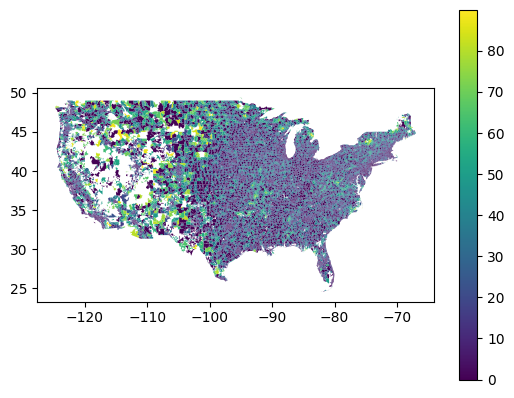

In [36]:
results.plot(column="minutes", legend=True)  # for debugging

In [37]:
results.drop(columns=["geometry"]).to_csv(os.path.join(RESULT_FOLDER, "access_result.csv"))